# For Testing Purposes

In [46]:

import pandas as pd
import json
import ast
from datetime import datetime
import numpy as np


In [14]:
excel_file = pd.read_excel('/Users/julienh/Desktop/ScrapingProjects/tax_scraper/ALLQuickRefNumbers.xlsx', sheet_name='2025-01-17_006376_APPRAISAL_INF')

In [15]:
excel_file.head()


,QuickRef
0,R100000
1,R100001
2,R100008
3,R100010
4,R100012


In [20]:
excel_file['QuickRef'].nunique()

112134

In [28]:
excel_file['QuickRef']

starts_with_R = excel_file[excel_file['QuickRef'].str.startswith('R')]
print(starts_with_R)

       QuickRef
0       R100000
1       R100001
2       R100008
3       R100010
4       R100012
...         ...
112128  R459238
112129  R459241
112130  R459247
112132  R459286
112133  R459290

[88280 rows x 1 columns]


We got a lot - 110k

We need to balance throughput / speed 

1000 rpm / second x 3 workers

In [29]:
ids = starts_with_R['QuickRef'].tolist()

In [30]:
ids[:20]

['R100000',
 'R100001',
 'R100008',
 'R100010',
 'R100012',
 'R100013',
 'R100014',
 'R100015',
 'R100016',
 'R100017',
 'R100018',
 'R100019',
 'R100020',
 'R100021',
 'R100022',
 'R100024',
 'R100045',
 'R100046',
 'R100047',
 'R100048']

In [31]:
with open('id_list.txt', 'w') as f:
    for id in ids:
        f.write(f"{id}\n")

## Processing the scraped data

In [32]:
tax_results = pd.read_csv('tax_results.csv')

tax_results

,Property ID,Result
0,R118484,"{'total_due': '$102.23', 'payment_history': [[..."
1,R260616,"{'total_due': 'Could not find total due', 'pay..."
2,R125700,"{'total_due': '$0.00', 'payment_history': [['2..."
3,R129488,"{'total_due': '$0.00', 'payment_history': [['2..."
4,R142500,"{'total_due': '$5,821.79', 'payment_history': ..."
5,R407712,"{'total_due': 'Could not find total due', 'pay..."
6,R159198,"{'total_due': '$86,055.56', 'payment_history':..."
7,R171241,"{'total_due': '$0.00', 'payment_history': 'Cou..."
8,R391145,"{'total_due': 'Could not find total due', 'pay..."
9,R124449,"{'total_due': '$0.00', 'payment_history': [['2..."


In [ ]:

# Convert the string representation of dictionaries to actual dictionaries
def parse_result(result_str):
    try:
        return ast.literal_eval(result_str)
    except:
        return {'total_due': 'Error parsing', 'payment_history': []}

# Convert currency string to float
def currency_to_float(currency_str):
    if not isinstance(currency_str, str):
        return np.nan
    
    if 'Could not find total due' in currency_str or currency_str == 'N/A':
        return np.nan
    
    try:
        clean_str = currency_str.replace('$', '').replace(',', '')
        return float(clean_str)
    except:
        return np.nan

# Convert date string to datetime
def safe_parse_date(date_str):
    if not date_str or not isinstance(date_str, str):
        return pd.NaT
    
    try:
        return pd.to_datetime(date_str, format='%m-%d-%Y')
    except:
        return pd.NaT

# Convert payment amount to float
def payment_to_float(payment_str):
    if not payment_str or not isinstance(payment_str, str):
        return np.nan
    return currency_to_float(payment_str)

# Extract the most recent payment history entry
def get_latest_payment(payment_history):
    if isinstance(payment_history, str) or not payment_history:
        return {
            'Latest Tax Year': np.nan,
            'Transaction Date': pd.NaT,
            'Effective Date': pd.NaT,
            'Payment Amount': np.nan,
            'Receipt Number': np.nan
        }
    
    try:
        # Convert dates to datetime objects for proper comparison
        dated_entries = []
        for entry in payment_history:
            try:
                date_obj = pd.to_datetime(entry[1], format='%m-%d-%Y')
                dated_entries.append((date_obj, entry))
            except:
                continue
        
        # Sort by date in descending order and get the most recent entry
        if dated_entries:
            dated_entries.sort(reverse=True)
            latest = dated_entries[0][1]
            
            return {
                'Latest Tax Year': latest[0] if latest[0] else np.nan,
                'Transaction Date': safe_parse_date(latest[1]),
                'Effective Date': safe_parse_date(latest[2]),
                'Payment Amount': payment_to_float(latest[3]),
                'Receipt Number': latest[4] if latest[4] else np.nan
            }
            
    except Exception as e:
        print(f"Error processing payment history: {e}")
    
    return {
        'Latest Tax Year': np.nan,
        'Transaction Date': pd.NaT,
        'Effective Date': pd.NaT,
        'Payment Amount': np.nan,
        'Receipt Number': np.nan
    }


In [47]:

# Process the tax results
processed_data = []

for _, row in tax_results.iterrows():
    property_id = row['Property ID']
    result_dict = parse_result(row['Result'])
    
    total_due_str = result_dict.get('total_due', 'N/A')
    total_due_float = currency_to_float(total_due_str)
    payment_history = result_dict.get('payment_history', [])
    
    latest_payment = get_latest_payment(payment_history)
    
    # Create a structured record
    record = {
        'Property ID': property_id,
        'Total Due': total_due_float,
        **latest_payment  # Unpack the latest payment dictionary
    }
    
    processed_data.append(record)

# Create a structured DataFrame
structured_df = pd.DataFrame(processed_data)

# Display the structured table
structured_df

,Property ID,Total Due,Latest Tax Year,Transaction Date,Effective Date,Payment Amount,Receipt Number
0,R118484,102.23,2023,2024-02-27,2024-02-26,115.58,SH-2024-1820136
1,R260616,NaN,NaN,NaT,NaT,NaN,NaN
2,R125700,0.00,2024,2025-01-27,2025-01-26,4027.46,SH-2025-1905579
3,R129488,0.00,2024,2025-01-14,2025-01-14,281.65,SH-2025-1893565
4,R142500,5821.79,2021,2022-02-17,2022-01-31,1116.84,SH-2022-1606784
5,R407712,NaN,NaN,NaT,NaT,NaN,NaN
6,R159198,86055.56,2023,2024-04-03,2024-04-01,81655.08,SH-2024-1825900
7,R171241,0.00,NaN,NaT,NaT,NaN,NaN
8,R391145,NaN,NaN,NaT,NaT,NaN,NaN
9,R124449,0.00,2024,2024-12-13,2024-12-13,19.49,WB-2024-69740


<Axes: >

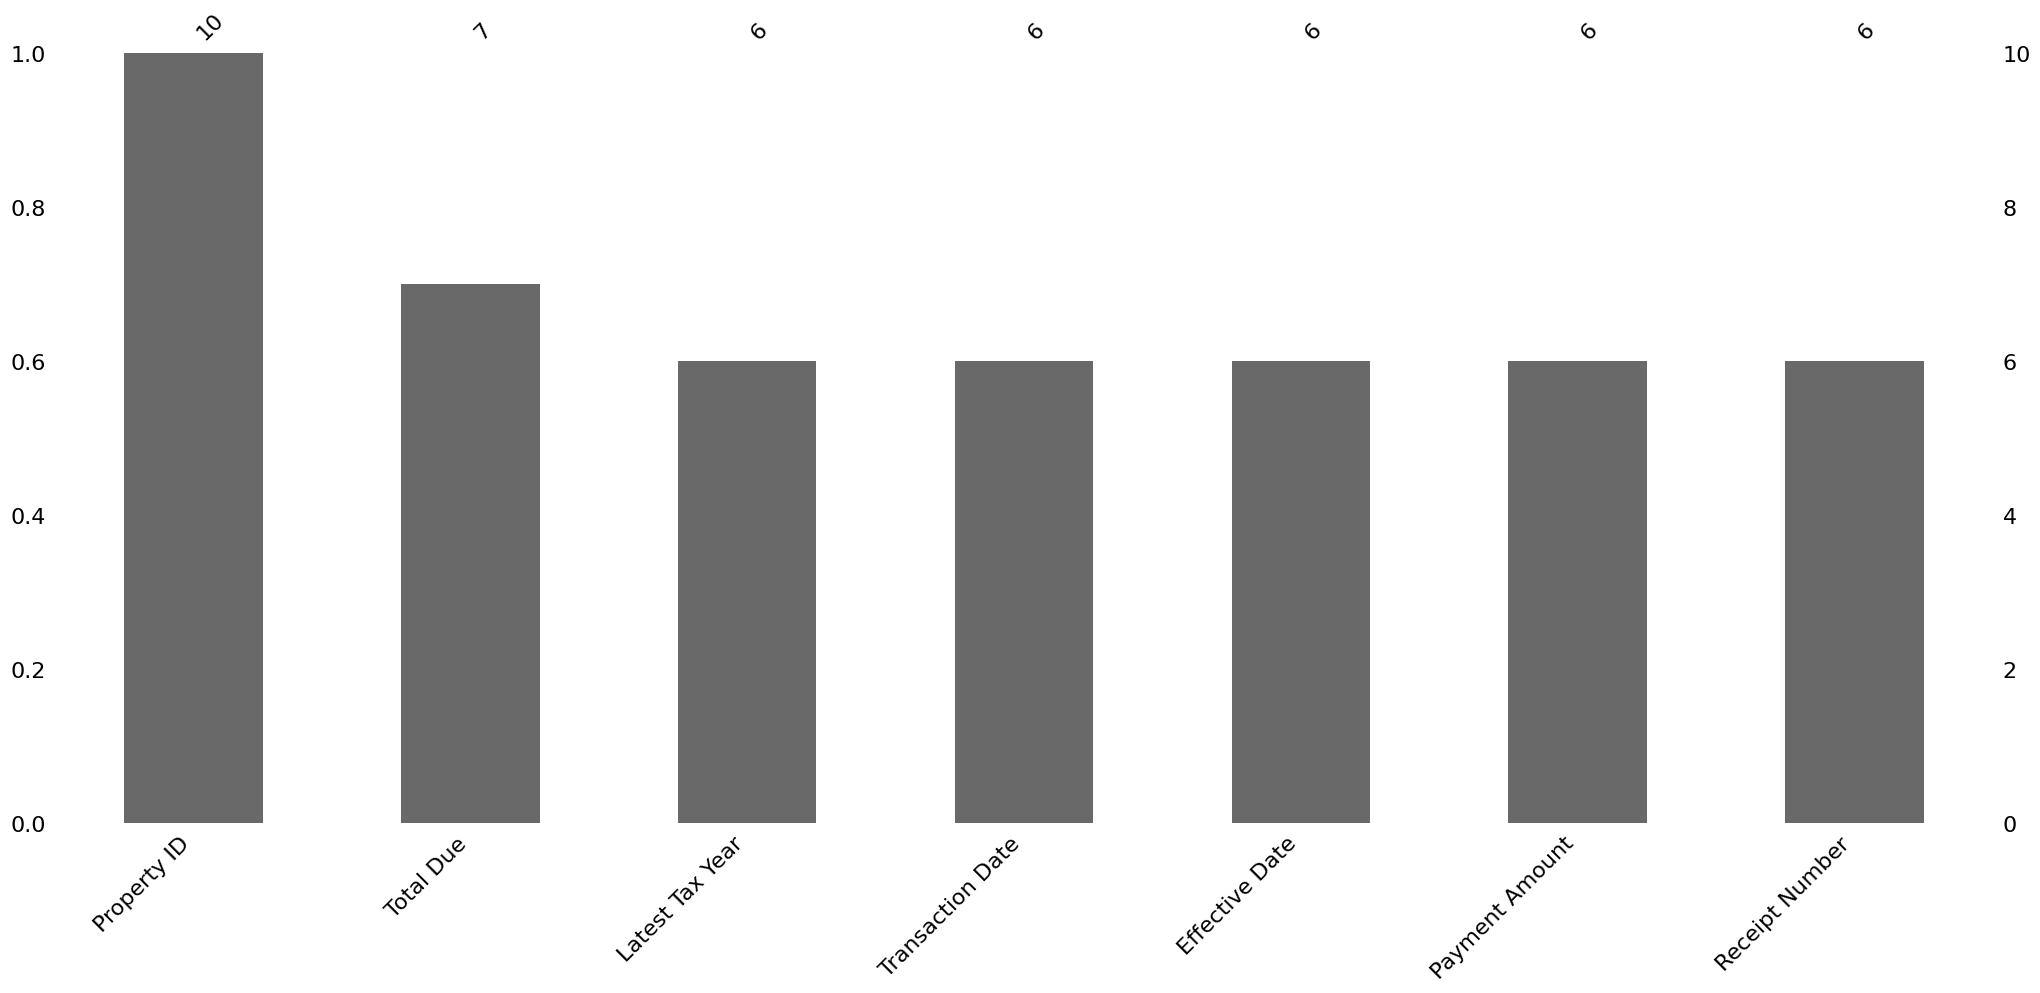

In [48]:
import missingno as msno
msno.bar(structured_df)

<Axes: >

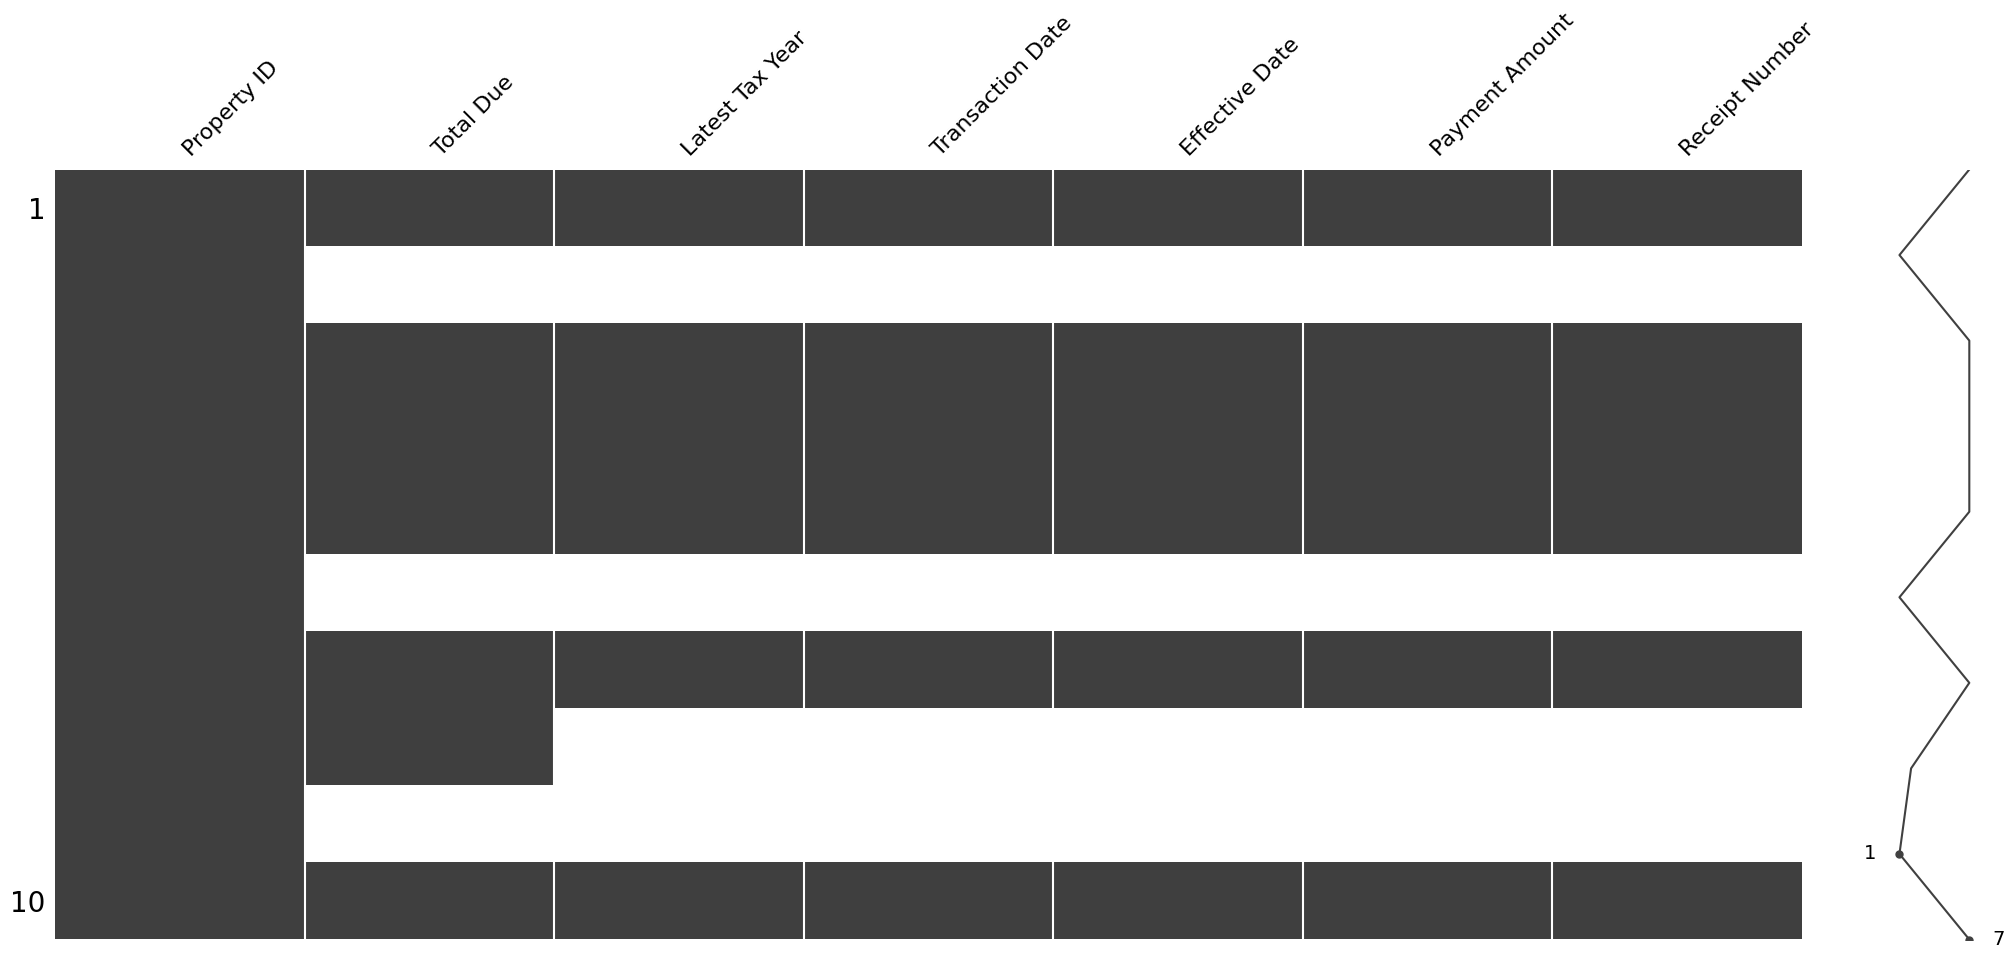

In [49]:
msno.matrix(structured_df)